# ECE-6524 / CS-6524 Deep Learning
# Assignment 1

In this assignment, **you need to complete the following three sectoins**:
1. SVM Classifier
    - Calculating loss and gradient
2. Linear Classfier with Softmax 
    - Calculating loss and gradient
3. Simple Neural Network with Multilayer Perceptrons
    - Read the forward and backward propogation
    - Experiment with simple NN

This assignment is inspired and adopted from Stanford CS231n, UIUC Deep Learning course and Deep Learning Lab from Professor Vicente Ordonez at the University of Virginia.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Zip BOTH the PDF file and this notebook. Rem
8. Submit your zipped file.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. numupy
2. matplotlib
3. scipy
```
All packages above can be installed through `pip install`.

In addition, you will need to have [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in your `cifar10/cifar-10-batches-py` folder. We provide a bash script `cifar10/get_dataset.sh` to help you download and unpack the dataset.

Once you are done with the things above, you can proceed to execute the following cells:

In [1]:
import random
import numpy as np
from data_process import get_CIFAR10_data
import math
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Loading CIFAR-10

In the following cells, we would first load the CIFAR10 dataset, and prepare them for our classifier:

In [2]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 1000

In [3]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES, subtract_mean=False)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

Now, we visualize the dataset to get a better idea of it.

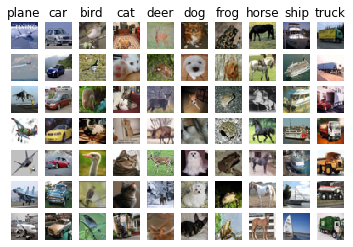

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

We then subtract all the images with the **mean image** of the training set. This trick is commonly used in Computer Vision community, as it arranges the features into a range that is more manageable for the models.

In [5]:
mean_image = np.mean(X_train, axis=0)
print(X_train.shape)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

(49000, 32, 32, 3)


Now, we convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector. This allows us to feed the data into our classifiers.

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

Here, we concatenate all the features with ones. This trick is particularly convenient, as in this case, we only need to deal with a single weight matrix $W$ instead of both $W$ and bias $b$ in our training code.

In [7]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [8]:
# you should get the following output:
# (49000, 3073)
# (1000, 3073)
# (1000, 3073)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3073)
(1000, 3073)
(1000, 3073)


### Calculate Classification Accuracy

Here is a simple helper function for calculation the classification accuracy:

In [9]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

# Section 1. Support Vector Machines (with SGD) [30 pts]

In this section, you will need to implement a **soft margin SVM** for a **multi-class classification problem**. In the soft margin SVM, you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

## 1.1. Implementing SVM with SGD [25 pts]

Recall that the multiclass SVM loss can be written as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = \sum_{j\neq y_i} \left[ \max(0, s_j - s_{y_i} + margin) \right]
\end{gathered}
\end{align}
where $s={s_j}$ is the vector of prediction scores of all class, $s_j$ is the prediction score for class $j$, and $y_i$ is the groud truth class label. The margin is usually set to 1. Now, to learn the weights $W$, we can differentiate the function $L_i$ to get the gradient:
\begin{equation}
\begin{gathered}
\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) \right) x_i\\
\end{gathered}
\end{equation}
where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise, and $w_j$ represents the row $j$ in your weight matrix $W$. To implement this, you’d simply count the number of classes that didn’t meet the desired margin 1 (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Note that, in the equation above, we are only calculating the gradient with respect to the row of $W$ that corresponds to the correct class $y_i$. For the other rows $j\neq y_i$, we have:
\begin{equation}
\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) x_i
\end{equation}
Now, we have derived the gradient expression above, it is time to turn these equations into the actual running code.
We provide a template for implementing your SVM classfier below. You have to fill in the **TODO** part, and train your classifier.

In [10]:
 
class SVM():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
        
    def calc_grad_and_loss(self, X_train, y_train, reg, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
        """
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        
#         # Normalize data ahead of time
#         def normalize_rows(x: np.ndarray):
#             """
#             function that normalizes each row of the matrix x to have unit length.

#             Args:
#              ``x``: A numpy matrix of shape (n, m)

#             Returns:
#              ``x``: The normalized (by row) numpy matrix.
#             """
#             return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)
        
#         X_train = normalize_rows(X_train)
        
        
        # X_train is [200 x 3073]
        # y_train is [200 x 1]
        # self.w is [3073 x 10]
        # S_j is [200x10]
        S_j = X_train.dot(self.w)
        # s_y is [200x1]
        s_y = S_j[np.arange(S_j.shape[0]),y_train]
        
        Margins = np.maximum(0, S_j - np.matrix(s_y).T + margin)
        
        # At this point, we will have Margins = [200x10], entries corresponding to
        # y_train will be m. We need to make them zero in the next step
        Margins[np.arange(Margins.shape[0]), y_train] = 0
        
        # Sum along the rows to get [200 x 1] because for each training point we want an overall
        # loss
        l_i = np.sum(Margins, axis=1)
        
        # Data loss:
        #loss = np.mean(l_i, axis=0)
        loss = np.mean(l_i)       
        # Add in regularization parameter, assuming L2 regularization. Element-wise multiply w, then
        # sum along all axes and multiply reg parameter:
        loss += 0.5*reg * np.sum(self.w * self.w)
        #scalar_loss = loss.item()
        scalar_loss = loss
        
        # Next ,we want to get the gradient. We can reuse Margins, because it already contains S_j * s_y + m
        # For gradient where j != y_i, elements will be positive while for elements where j == y_i, negative.
        
        #indicator = np.zeros(Margins.shape)
        indicator = Margins
        indicator[Margins>0] = 1
        row_sum = np.sum(indicator, axis=1)
        #import pdb; pdb.set_trace()
        indicator[np.arange(X_train.shape[0]), y_train] = -row_sum.T
        grad_w = np.dot(X_train.T, indicator)
        #print(grad_w.shape)
        # Average

        grad_w /= X_train.shape[0]

        # Regularize
        grad_w += 1*reg*self.w
        #import pdb; pdb.set_trace()        

        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return grad_w, scalar_loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200):
        """
        Train SVM classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        
        result = np.dot(X_test, self.w)
        #pred = 1 - result
        #pred = np.absolute(pred)
        pred = result
        pred = np.argmax(pred, axis=1)
        #import pdb; pdb.set_trace()
        pred = list(pred.T)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred
    


# Train your SVM
Now, train your SVM classifier. You should expect the loss decreases as the training goes on.

In [11]:
# #Test with liblinear
# from sklearn import svm
# clf = svm.SVC(max_iter=200, verbose=1)
# clf.fit(X_train, y_train)

# #import pdb; pdb.set_trace()

# pred_svm = clf.predict(X_test)
# print(pred_svm)
# print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
# import pdb; pdb.set_trace()
# #End of liblinear test ############################

# Start of actual code
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
svm = SVM(num_features, num_classes)
loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,)


Iter 100/1500 - loss: 78.73066741337689 
Iter 200/1500 - loss: 72.62469694351209 
Iter 300/1500 - loss: 62.82549770340044 
Iter 400/1500 - loss: 57.95811835842798 
Iter 500/1500 - loss: 52.51674086075007 
Iter 600/1500 - loss: 47.689523187794926 
Iter 700/1500 - loss: 43.31472565344741 
Iter 800/1500 - loss: 39.184241854781575 
Iter 900/1500 - loss: 36.190573009026025 
Iter 1000/1500 - loss: 32.8732370643184 
Iter 1100/1500 - loss: 30.71095049311483 
Iter 1200/1500 - loss: 27.234993492491334 
Iter 1300/1500 - loss: 25.285757624208614 
Iter 1400/1500 - loss: 23.221707345276993 
Iter 1500/1500 - loss: 21.85110160409618 


### Plot the Loss Curve
Plotting the loss curve is a proper etiquette for Machine Learning/Deep Learning practitioner.

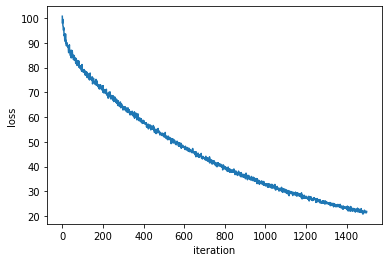

In [12]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an training/validation accuracy around 34%-35%.

In [14]:
pred_svm = svm.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_svm, y_train)))
pred_svm = svm.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

The training accuracy is given by : 34.457143
The validation accuracy is given by : 35.100000


## Section 1.2. Improve your SVM [5 pts]
Now, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.**

In [16]:
# How can you improve it?
for i in range(1,10):
    svm = SVM(num_features, num_classes)
    loss_hist = svm.train(X_train, y_train, lr=1e-7, reg_const=i*5e3, n_iters=1500,)
    pred_svm = svm.predict(X_val)
    print('The validation accuracy is given by : %f' % (get_acc(pred_svm, y_val)))

Iter 100/1500 - loss: 81.68105522792457 
Iter 200/1500 - loss: 71.10406635611659 
Iter 300/1500 - loss: 65.94676235912733 
Iter 400/1500 - loss: 57.161807303518636 
Iter 500/1500 - loss: 53.11281377347196 
Iter 600/1500 - loss: 47.7930926891495 
Iter 700/1500 - loss: 43.30967517991883 
Iter 800/1500 - loss: 39.8392146278344 
Iter 900/1500 - loss: 35.458607008437596 
Iter 1000/1500 - loss: 32.62164105693766 
Iter 1100/1500 - loss: 30.048544069591017 
Iter 1200/1500 - loss: 27.88382790261588 
Iter 1300/1500 - loss: 27.103446528288746 
Iter 1400/1500 - loss: 23.695894689876766 
Iter 1500/1500 - loss: 21.42422005908722 
The validation accuracy is given by : 34.300000
Iter 100/1500 - loss: 138.29469615805286 
Iter 200/1500 - loss: 111.9426153723516 
Iter 300/1500 - loss: 92.44534149314751 
Iter 400/1500 - loss: 75.64353036680706 
Iter 500/1500 - loss: 62.69966594661397 
Iter 600/1500 - loss: 51.02561363322409 
Iter 700/1500 - loss: 42.96235055126912 
Iter 800/1500 - loss: 35.87529520538572 

### Test SVM
Finally, evaluate the testing accuracy of your SVM:

In [47]:
pred_svm = svm.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_svm, y_test)))

The testing accuracy is given by : 34.800000


# Section 2. Softmax Classifier (with SGD) [30 pts]

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. 

## Section 2.1. Implement the Softmax Classifier [25 pts]
Recall that, from the lecture, we can write down the loss function as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = -\log\left({\frac{e^{s_{y_i}}} {\sum_j e^{s_j}} }\right)
\end{gathered}
\end{align}

And, through some calculations, we can obtain the expression for the gradient:
\begin{align}
\nabla_{w_{l}} L_i = \left(\frac{e^{w_l^Tx_i}} {\sum_j e^{w_j^Tx_i}} - \mathbb{1}\left(y_i=l\right)\right) x_i\\
\end{align}


The softmax classifier also has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

Same as the previous section, we provide a template for you to implement your classifier:

In [107]:
 class Softmax_Classfier():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001
    
    def softmax(self, logits):
        ################################################################################
        # TODO:                                                                        #
        # Implement the softmax function here.                                         #
        ################################################################################
        num_samples = logits.shape[0]
        num_features = logits.shape[1]
        
        # Element-wise exponential, shape = [N x C]
        Exp_logits = np.exp(logits)
        
        # To normalize, divide by the sum which is [N x 1]. Normalized Exp_logits is still [N x C]
        sums = np.sum(Exp_logits, axis=1)

        Exp_logits_normalized = np.zeros((num_samples, num_features))
        Exp_logits_normalized = Exp_logits / sums[:,None]
        
        probs = Exp_logits_normalized
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return probs
    
    def calc_grad_and_loss(self, X_train, y_train, reg_const, margin):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
         """ 
        ################################################################################
        # TODO:                                                                        #
        # Calculate the loss and gradient for the SVM classifier.                      #
        ################################################################################
        S = np.dot(X_train, self.w)     
        # Shape here is still [N x C]
        P_x = self.softmax(S)
        
        num_samples = X_train.shape[0]
        
        # Select the right ones according to y and -log them
        L = -np.log(P_x[np.arange(num_samples), y_train])
        #import pdb; pdb.set_trace()    
        # loss is the mean of L:
        loss = np.mean(L)
        # Add regularization
        loss += 0.5 * reg_const * np.sum(self.w * self.w)
        
        coefficient = P_x 
        coefficient[np.arange(num_samples), y_train] -= 1
        
        coefficient = np.dot(coefficient.T, X_train)
        grad_w = coefficient.T
        grad_w /= num_samples
    
        #import pdb; pdb.set_trace()   
        grad_w += reg_const * self.w

        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return grad_w, loss
        
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
              n_iters=1500, batch_size=200):
        """
        Train softmax classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - margin: A float number margin for the multi-class SVM loss (usually set to 1);
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        result = np.dot(X_test, self.w)
        #pred = 1 - result
        #pred = np.absolute(pred)
        pred = result
        pred = np.argmax(pred, axis=1)
        #import pdb; pdb.set_trace()
        pred = list(pred.T)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred


In [108]:
n_iter = 1500
batch_size = 200
num_classes = np.max(y_train) + 1
num_features = X_train.shape[1]
softmax_classifier = Softmax_Classfier(num_features, num_classes)
loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=5e3, n_iters=1500,)

Iter 100/1500 - loss: 74.03217106321044 
Iter 200/1500 - loss: 66.88253215693447 
Iter 300/1500 - loss: 60.02878224392149 
Iter 400/1500 - loss: 54.58282389621163 
Iter 500/1500 - loss: 49.661519651570494 
Iter 600/1500 - loss: 45.00320480289806 
Iter 700/1500 - loss: 40.62066338691346 
Iter 800/1500 - loss: 36.827261882324805 
Iter 900/1500 - loss: 33.50379322928469 
Iter 1000/1500 - loss: 30.34395613917625 
Iter 1100/1500 - loss: 27.564820643184166 
Iter 1200/1500 - loss: 25.304686859284477 
Iter 1300/1500 - loss: 22.92009291626608 
Iter 1400/1500 - loss: 20.949979672043003 
Iter 1500/1500 - loss: 18.93781023594413 


Again, plot the loss:

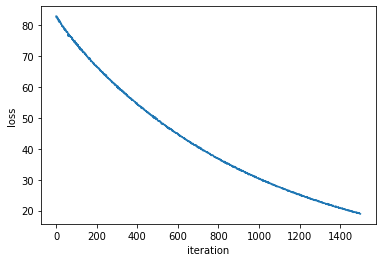

In [109]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the SVM is implemented correctly, you shuold get an accuracy around 29%.

In [110]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

The training accuracy is given by : 29.336735
The validation accuracy is given by : 31.700000


## Section 2.1. Improve your Softmax Classifier [5 pts]
Again, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.** In addition, <span style="color:red">**We expect to see an accuracy around 34% after the improvement.**</span>


In [111]:
# Get the accuracy to above 34%!
for i in range(1,10):
    softmax_classifier = Softmax_Classfier(num_features, num_classes)
    loss_hist = softmax_classifier.train(X_train, y_train, lr=1e-7, reg_const=i*5e3, n_iters=1500,)
    pred_softmax = softmax_classifier.predict(X_val)
    print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

Iter 100/1500 - loss: 72.03525497341354 
Iter 200/1500 - loss: 65.15975999744732 
Iter 300/1500 - loss: 58.802725291116786 
Iter 400/1500 - loss: 53.111414271518306 
Iter 500/1500 - loss: 47.980838719485924 
Iter 600/1500 - loss: 43.48372173445907 
Iter 700/1500 - loss: 39.6129926399655 
Iter 800/1500 - loss: 35.99734104681095 
Iter 900/1500 - loss: 32.61533843806872 
Iter 1000/1500 - loss: 29.63964719092144 
Iter 1100/1500 - loss: 26.9622754224981 
Iter 1200/1500 - loss: 24.522302412747862 
Iter 1300/1500 - loss: 22.25343371940564 
Iter 1400/1500 - loss: 20.19196302716491 
Iter 1500/1500 - loss: 18.55966939842736 
The validation accuracy is given by : 28.100000
Iter 100/1500 - loss: 128.04829964108697 
Iter 200/1500 - loss: 104.65447195694577 
Iter 300/1500 - loss: 85.93106382284982 
Iter 400/1500 - loss: 70.61739622693268 
Iter 500/1500 - loss: 58.02762908264207 
Iter 600/1500 - loss: 47.679504139715725 
Iter 700/1500 - loss: 39.38909507755718 
Iter 800/1500 - loss: 32.38126559014994

### Testing Softmax

Finally, evaluate the testing accuracy.

In [ ]:
pred_softmax = softmax_classifier.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

# Section 3. Multilayer Perceptron (MLP)
In this section, we present you a modified version of simple neural network from Professor Vicente Ordonez at the University of Virginia. You job is to read through the implementation (optional, but highly recommended), and try the MLP classifier. For additional resources on understanding forward and backpropagation, you can check the materials here: http://cs231n.github.io/optimization-2/

Consider a single-layer supervised neural network that has 4 inputs and 3 outputs. First, let's review the skeleton of a single linear layer neural network. The inputs of the network are the variables $x_1, x_2, x_3, x_4$, or the input vector $\mathbf{x}=[x_1, x_2, x_3, x_4]$, the outputs of the network are $\widehat{y}_1,\widehat{y}_2,\widehat{y}_3$, or the output vector $\widehat{\mathbf{y}}=[$$\widehat{y}$$_1,\widehat{y}_2,\widehat{y}_3]$:

<img src="fig/1_layer_fig.png" width="450"/>

The given $j$-th output $\widehat{y}_j$ of this single linear layer + activation function is computed as follows:

$$\widehat{y}_j= \text{sigmoid}(w_{1j}x_1 + w_{2j}x_2 + w_{3j}x_3 + w_{4j}x_4 + b_j) = \text{sigmoid}\Big(\sum_{i=1}^{i=4}w_{ij}x_{i} + b_j\Big)$$

In matrix notation, this would be: 

\begin{equation}
\begin{bmatrix}
  \widehat{y}_{1} \\ 
  \widehat{y}_{2} \\
  \widehat{y}_{3} 
\end{bmatrix}^T=\mathbf{Sigmoid}\Bigg(
\begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4}
\end{bmatrix}^T
\begin{bmatrix}
  w_{1,1} & w_{1,2} & w_{1,3}\\
  w_{2,1} & w_{3,2} & w_{2,3}\\
  w_{3,1} & w_{3,2} & w_{3,3}\\
  w_{4,1} & w_{4,2} & w_{4,3}
\end{bmatrix}
+
\begin{bmatrix}
  b_{1} \\
  b_{2} \\
  b_{3}
\end{bmatrix}^T\Bigg)
\end{equation}

or more compactly:

\begin{equation}
\widehat{\mathbf{y}}^T = \mathbf{Sigmoid}(\mathbf{x}^T \cdot \mathbf{W} + \mathbf{b}^T)
\end{equation}

The element-wise sigmoid function is: $\mathbf{Sigmoid}(\mathbf{x}) = 1 \;/\; (1 + exp(-\mathbf{x}))$, or alternatively: $\mathbf{Sigmoid}(\mathbf{x}) = exp(\mathbf{x})\;/\;(1 + exp(\mathbf{x}))$. Here the sigmoid is separated logically into an activation layer $\sigma(x)$ and a linear layer $\text{linear}(3,4)$ as illustrated in figure. 

Training these weights $\mathbf{W}$ and biases $\mathbf{b}$ requires having many training pairs $(\widehat{\mathbf{y}}^{(m)}, \mathbf{x}^{(m)})$. The inputs $\mathbf{x}$ can be the pixels of an image, indices of words, the entries in a database, and the outputs $\widehat{\mathbf{y}}$ can also be literally anything, including a number indicating a category, a set of numbers indicating the indices of words composing a sentence, an output image itself, etc.

## 3.1. Forward-propagation

Computing the outputs $\widehat{\mathbf{y}}$ from the inputs $\mathbf{x}$ in this network composed of a single linear layer, and a sigmoid layer, is called forward-propagation. Below is the code that implements these two operations:

In [ ]:
import numpy as np
import numpy.matlib

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        
    # y = Wx + b
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def getParameters(self):
        return [self.weight, self.bias]

# Let's test the composition of the two functions (forward-propagation in the neural network).
x1 = np.array([[1, 2, 2, 3]])
y_hat1 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x1))
print('x[1] = '+ str(x1))
print('y_hat[1] = ' + str(y_hat1) + '\n')

# Let's test the composition of the two functions (forward-propagation in the neural network).
x2 = np.array([[4, 5, 2, 1]])
y_hat2 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x2))
print('x[2] = '+ str(x2))
print('y_hat[2] = ' + str(y_hat2) + '\n')

# We can also compute both at once, which could be more efficient since it requires a single matrix multiplication.
x = np.concatenate((x1, x2), axis = 0)
y_hat = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x))
print('x = ' + str(x))
print('y_hat = ' + str(y_hat))

## 3.2. Loss functions.

After computing the output predictions $\widehat{\mathbf{y}}$ it is necessary to compare these against the true values of $\mathbf{y}$. Let's call these true, correct, or desired values $\mathbf{y}$. Typically, a simple loss or cost function is used to measure the degree by which the prediction $\widehat{\mathbf{y}}$ is wrong with respect to $\mathbf{y}$. A common loss function for regression is the sum of squared differences between the prediction and its true value. Assuming a prediction $\widehat{\mathbf{y}}^{(d)}$ for our training sample $\mathbf{x}^{(d)}$ with true value $\mathbf{y}^{(d)}$, then the loss can be computed as:

$$loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)}) = (\widehat{y}^{(d)}_1 - y^{(d)}_1)^2 + (\widehat{y}^{(d)}_2 - y^{(d)}_2)^2 + (\widehat{y}^{(d)}_3 - y^{(d)}_3)^2 = \sum_{j=1}^{j=3}(\widehat{y}^{(d)}_j - y^{(d)}_j)^2$$

The goal is to modify the parameters [$\mathbf{W}, \mathbf{b}$] in the Linear layer so that the value of $loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$ becomes as small as possible for all training samples in a set $D=\{(\mathbf{x}^{(d)},\mathbf{y}^{(d)})\}$. This would in turn ensure that predictions $\widehat{\mathbf{y}}$ are as similar as possible to the true values $\mathbf{y}$. To achieve this we need to minimize the following function:

$$\mathcal{L}(\mathbf{W}, \mathbf{b}) = \sum_{d=1}^{d=|D|} loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$$

The only two variables for our model in the function $\mathcal{L}(\mathbf{W}, \mathbf{b})$ are $\mathbf{W}$ and $\mathbf{b}$, this is because the training dataset $D$ is fixed. Finding the values of $\mathbf{W}$ and $\mathbf{b}$ that minimize the the loss, particularly for complex functions, is typically done using gradient based optimization, like Stochastic Gradient Descent (SGD). 

In [ ]:
class nn_MSECriterion:  # MSE = mean squared error.
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))

# Let's test the loss function.
y_hat = np.array([[0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33]])
y_true = np.array([[0.25, 0.25, 0.25], [0.33, 0.33, 0.33], [0.77, 0.77, 0.77], [0.80, 0.80, 0.80]])

nn_MSECriterion().forward(y_hat, y_true)

## 3.3. Backward-propagation (Backpropagation)

As we discussed in class, backpropagation is just applying the chain-rule in calculus to compute the derivative of a function which is the composition of many functions (this is essentially definition of the neural network). 

Below is the implementation of required derivative computations for our simple network. You are highly advised to derive the derivatives implemented here to make sure you understand how one arrives at them. 

In [ ]:
# This is referred above as f(u).

class nn_MSECriterion:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels):
        num_samples = labels.shape[0]
        return 2 * (predictions - labels)
    
# This is referred above as g(v).
class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x))
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

# This is referred above as h(W, b)
class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)
        
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x, gradOutput):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        #self.gradBias = np.copy(gradOutput)
        self.gradBias = np.copy(np.sum(gradOutput, axis=0))
        # return dL/dx = dh/dx * dL/dv
        return np.dot(gradOutput, self.weight.T)
    
    def getParameters(self):
        params = [self.weight, self.bias]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams
    
# Let's test some dummy inputs for a full pass of forward and backward propagation.
x1 = np.array([[1, 2, 2, 3]])
y1 = np.array([[0.25, 0.25, 0.25]])

# Define the operations.
linear = nn_Linear(4, 3)  # h(W, b)
sigmoid = nn_Sigmoid()  # g(v)
loss = nn_MSECriterion()  # f(u)

# Forward-propagation.
lin = linear.forward(x1)
y_hat = sigmoid.forward(lin)
loss_val = loss.forward(y_hat, y1) # Loss function.

# Backward-propagation.
dy_hat = loss.backward(y_hat, y1)
dlin = sigmoid.backward(lin, dy_hat)
dx1 = linear.backward(x1, dlin)

print('\n num_samples = ' + str(y1.shape[0]))

# Show parameters of the linear layer.
print('\nW = ' + str(linear.weight))
print('B = ' + str(linear.bias))

# Show the intermediate outputs in the forward pass.
print('\nx1    = '+ str(x1))
print('lin   = ' + str(lin))
print('y_hat = ' + str(y_hat))

print('\nloss = ' + str(loss_val))

# Show the intermediate gradients with respect to inputs in the backward pass.
print('\ndy_hat = ' + str(dy_hat))
print('dlin   = ' + str(dlin))
print('dx1    = ' + str(dx1))

# Show the gradients with respect to parameters.
print('\ndW = ' + str(linear.gradWeight))
print('dB = ' + str(linear.gradBias))

## 3.4. Gradient checking 

The gradients can also be computed with numerical approximation using the definition of derivatives. Let a single input pair $(\mathbf{x}, \mathbf{y})$ be the input, for each entry $w_{ij}$ in the weight matrix $\mathbf{W}$, the partial derivatives can be computed as follows:

$$\frac{\partial \mathcal{L}(\mathbf{W},\mathbf{b})}{\partial w_{ij}} = \frac{\mathcal{L}(\mathbf{W} + \mathbf{E}_{ij},b) - \mathcal{L}(\mathbf{W} - \mathbf{E}_{ij}, b)}{2\epsilon}, $$

where $\mathbf{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeros everywhere else. Intuitively this gradient tells how would the value of the loss changes if we change a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Below is the code that checks for a given input $(\mathbf{x}, \mathbf{y})$, the gradients for the matrix $\mathbf{W}$. 

In [ ]:
# We will compute derivatives with respect to a single data pair (x,y)
x = np.array([[2.34, 3.8, 34.44, 5.33]])
y = np.array([[3.2, 4.2, 5.3]])

# Define the operations.
linear = nn_Linear(4, 3)
sigmoid = nn_Sigmoid()
criterion = nn_MSECriterion()

# Forward-propagation.
a0 = linear.forward(x)
a1 = sigmoid.forward(a0)
loss = criterion.forward(a1, y) # Loss function.

# Backward-propagation.
da1 = criterion.backward(a1, y)
da0 = sigmoid.backward(a0, da1)
dx = linear.backward(x, da0)

gradWeight = linear.gradWeight
gradBias = linear.gradBias

approxGradWeight = np.zeros_like(linear.weight)
approxGradBias = np.zeros_like(linear.bias)

# We will verify here that gradWeights are correct and leave it as an excercise
# to verify the gradBias.
epsilon = 0.0001
for i in range(0, linear.weight.shape[0]):
    for j in range(0, linear.weight.shape[1]):
        # Compute f(w)
        fw = criterion.forward(sigmoid.forward(linear.forward(x)), y) # Loss function.
        # Compute f(w + eps)
        shifted_weight = np.copy(linear.weight)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        shifted_linear = nn_Linear(4, 3)
        shifted_linear.bias = linear.bias
        shifted_linear.weight = shifted_weight
        fw_epsilon = criterion.forward(sigmoid.forward(shifted_linear.forward(x)), y) # Loss function
        # Compute (f(w + eps) - f(w)) / eps
        approxGradWeight[i, j] = (fw_epsilon - fw) / epsilon

# These two outputs should be similar up to some precision.
print('gradWeight: ' + str(gradWeight))
print('\napproxGradWeight: ' + str(approxGradWeight))

## Section 3.4. Playing with the Simple NN [40 pts]
Now, we provide a simple NN model that has an training accuracy around 46%. You job here is to first run and check the simple NN model, and the experiments it with:
- Try using 3 different numbers of layers for the simple NN, and plot the accuracy as a function of the number of layers. 
- Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried.
- Try different activation function (Sigmoid, ReLU)
- Briefly describe what you've observed in the above experiments

Note that you are free to create your own Simple_NN class for your experiments.

In [ ]:
class nn_CECriterionWithLogits:
    def forward(self, logits, labels):
        y_indices = np.arange(len(labels))
        self.probs = softmax(logits)
        correct_class_prob = self.probs[y_indices, labels].reshape(-1, 1)
        loss = np.sum(-np.log(correct_class_prob)) / len(correct_class_prob)
        return loss
    
    def backward(self, labels):
        y_indices = np.arange(len(labels))
        gradOutput = self.probs
        gradOutput[y_indices, labels] -= 1
        return gradOutput / len(labels)
    
class nn_ReLU:
    def forward(self, x):
        # Forward pass.
        return np.maximum(0, x)
    
    def backward(self, x, gradOutput):
        # Backward pass
        return np.where(x < 0, 0, np.multiply(x, gradOutput))
    
def softmax(x):
    exp = np.exp(x - x.max()) # stability trick
    return (exp / np.sum(exp, axis=1))

In [ ]:
class Simple_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.bias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

As the bias is explicitly handled in the MLP code, stripped off the ones we have concatenated to the feature vectors.

In [ ]:
X_train = X_train[:, :3072]
X_val = X_val[:, :3072]
X_test = X_test[:, :3072]

Now, run the simple NN to check the accuracy:

In [ ]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

In [ ]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))

### Section 3.4.1. Different numbers of layers [15 pts]
Try building 3 simple NN with different numbers of layers. Plot the training/validation/test accuracy as a function of the numbers of layers.

In [ ]:
# Your code goes here

### Section 3.4.2. Different numbers of hidden state size [10 pts]
Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried. We recommend you to test numbers like 8, 16, 32, 64, 128, 256. Plot the training/validation/test accuracy as a function of the hidden state size your picked.

In [ ]:
# Your code goes here

### Section 3.4.3. Different activation functions [10 pts]
Try both ReLU and Sigmoid activation, and report the training/validation/test accuracy.

In [ ]:
# Your code goes here

### Section 3.4.4. What did you see? [5 pts]
Desribe what you see in the experiments above in 5-6 sentences.

In [ ]:
# Your code goes here